In [42]:
%matplotlib inline
import pandas as pd
import glob
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
!ls Transients_with_charging_plugin_info_05_02_to_23_09/

df_transients_charging_plugin_05 df_transients_charging_plugin_08
df_transients_charging_plugin_06 df_transients_charging_plugin_09
df_transients_charging_plugin_07


In [3]:
def load_pkl(path):
    filenames = glob.glob(path)

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_pickle(filename))
    concat_df = pd.concat(dfs, ignore_index=True)
    return concat_df

In [4]:
def convert_to_datetime(timestamp_as_str):
    """Convert a timestring as str to pandas timestring dtype

    Args:
        timestamp_as_str: Timestamp in string format

    Returns:
        A readable timestamp for pandas
    """
    date, time, time_ns = timestamp_as_str.split('_')
    return pd.to_datetime(date + ' ' + time + '.' + time_ns, dayfirst=True)

In [5]:
data = load_pkl('Transients_with_charging_plugin_info_05_02_to_23_09/*')
data['begin_timestamp_string'] = data['begin_timestamp_string'].apply(convert_to_datetime)
data = data.sort_values('begin_timestamp_string')
data = data.drop(['filtered_signal', 'raw_signal_current', 'raw_signal_voltage', 'transient_rise_gradient'], axis=1)

In [43]:
data.head(1)

,begin_timestamp_float_x,begin_index,begin_timestamp_string,phase_num,three_first_peaks,three_first_peaks_index,begin_timestamp_float_y,cars_total,one_phase,two_phases,...,cars_phase_1,cars_phase_2,cars_phase_3,plugin,plugin_phase_1,plugin_phase_2,plugin_phase_3,plugin_on_this_phase,cluster,max_peak
0,1.493604e+09,5604,2017-05-01 04:06:52.114772,2,"[25.251, 5.489, 2.660]","[5656, 5766, 5877]",1.493604e+09,0.0,0.0,0.0,...,0.0,0.0,0.0,False,False,False,False,NaN,1,25.251


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4474 entries, 0 to 2644
Data columns (total 19 columns):
begin_timestamp_float_x    4474 non-null float64
begin_index                4474 non-null int64
begin_timestamp_string     4474 non-null datetime64[ns]
phase_num                  4474 non-null int64
three_first_peaks          4474 non-null object
three_first_peaks_index    4474 non-null object
begin_timestamp_float_y    4474 non-null float64
cars_total                 4474 non-null float64
one_phase                  4474 non-null float64
two_phases                 4474 non-null float64
three_phases               4474 non-null float64
cars_phase_1               4474 non-null float64
cars_phase_2               4474 non-null float64
cars_phase_3               4474 non-null float64
plugin                     4474 non-null object
plugin_phase_1             4474 non-null object
plugin_phase_2             4474 non-null object
plugin_phase_3             4474 non-null object
plugin_on_this

# Clustering

Beschreibung der Cluster:

1: Transiente wenn kein Auto lädt oder angeschlossen wird

2: Transienten die während des Ladevorgangsauftreten, aber kein Plugin Event sind

3: Transienten die durch ein Plugin Event ausgelöst werden, dabei hat zuvor kein Auto geladen

4: Transienten die durch ein Plugin Event ausgelöst werden, allerdings mit zuvor geladenem Auto

In [9]:
def clustering_transients(row):
    if((row['cars_total'] == 0) & (not row['plugin'])):
        return 1
    else:
        if not (row['plugin']):
            return 2
        else:
            if(row['cars_total'] == 0):
                return 3
            else:
                return 4

In [10]:
%%timeit
data['cluster'] = data.apply(clustering_transients, axis=1)

436 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
data.to_pickle('clustering_transients.plk')

# Einleitung
Für die Transientenanalyse werden Daten von Mai bis September untersucht. In diesem Transientendatensatz sind 4474 Events enthalten. Zunächst soll untersucht werden wie sich die Transienten verhalten, wenn ein Auto angeschlossen und wenn keins angeschlossen ist. 

## Hypothese 1
Wenn ein Auto zum Laden angeschlossen wird tretten stärkere und mehr Transienten auf.

In [15]:
data['max_peak'] = data['three_first_peaks'].apply(lambda x: np.array(list(map(float, x))).max())

In [35]:
plot_data = data[data['max_peak'] < 120]

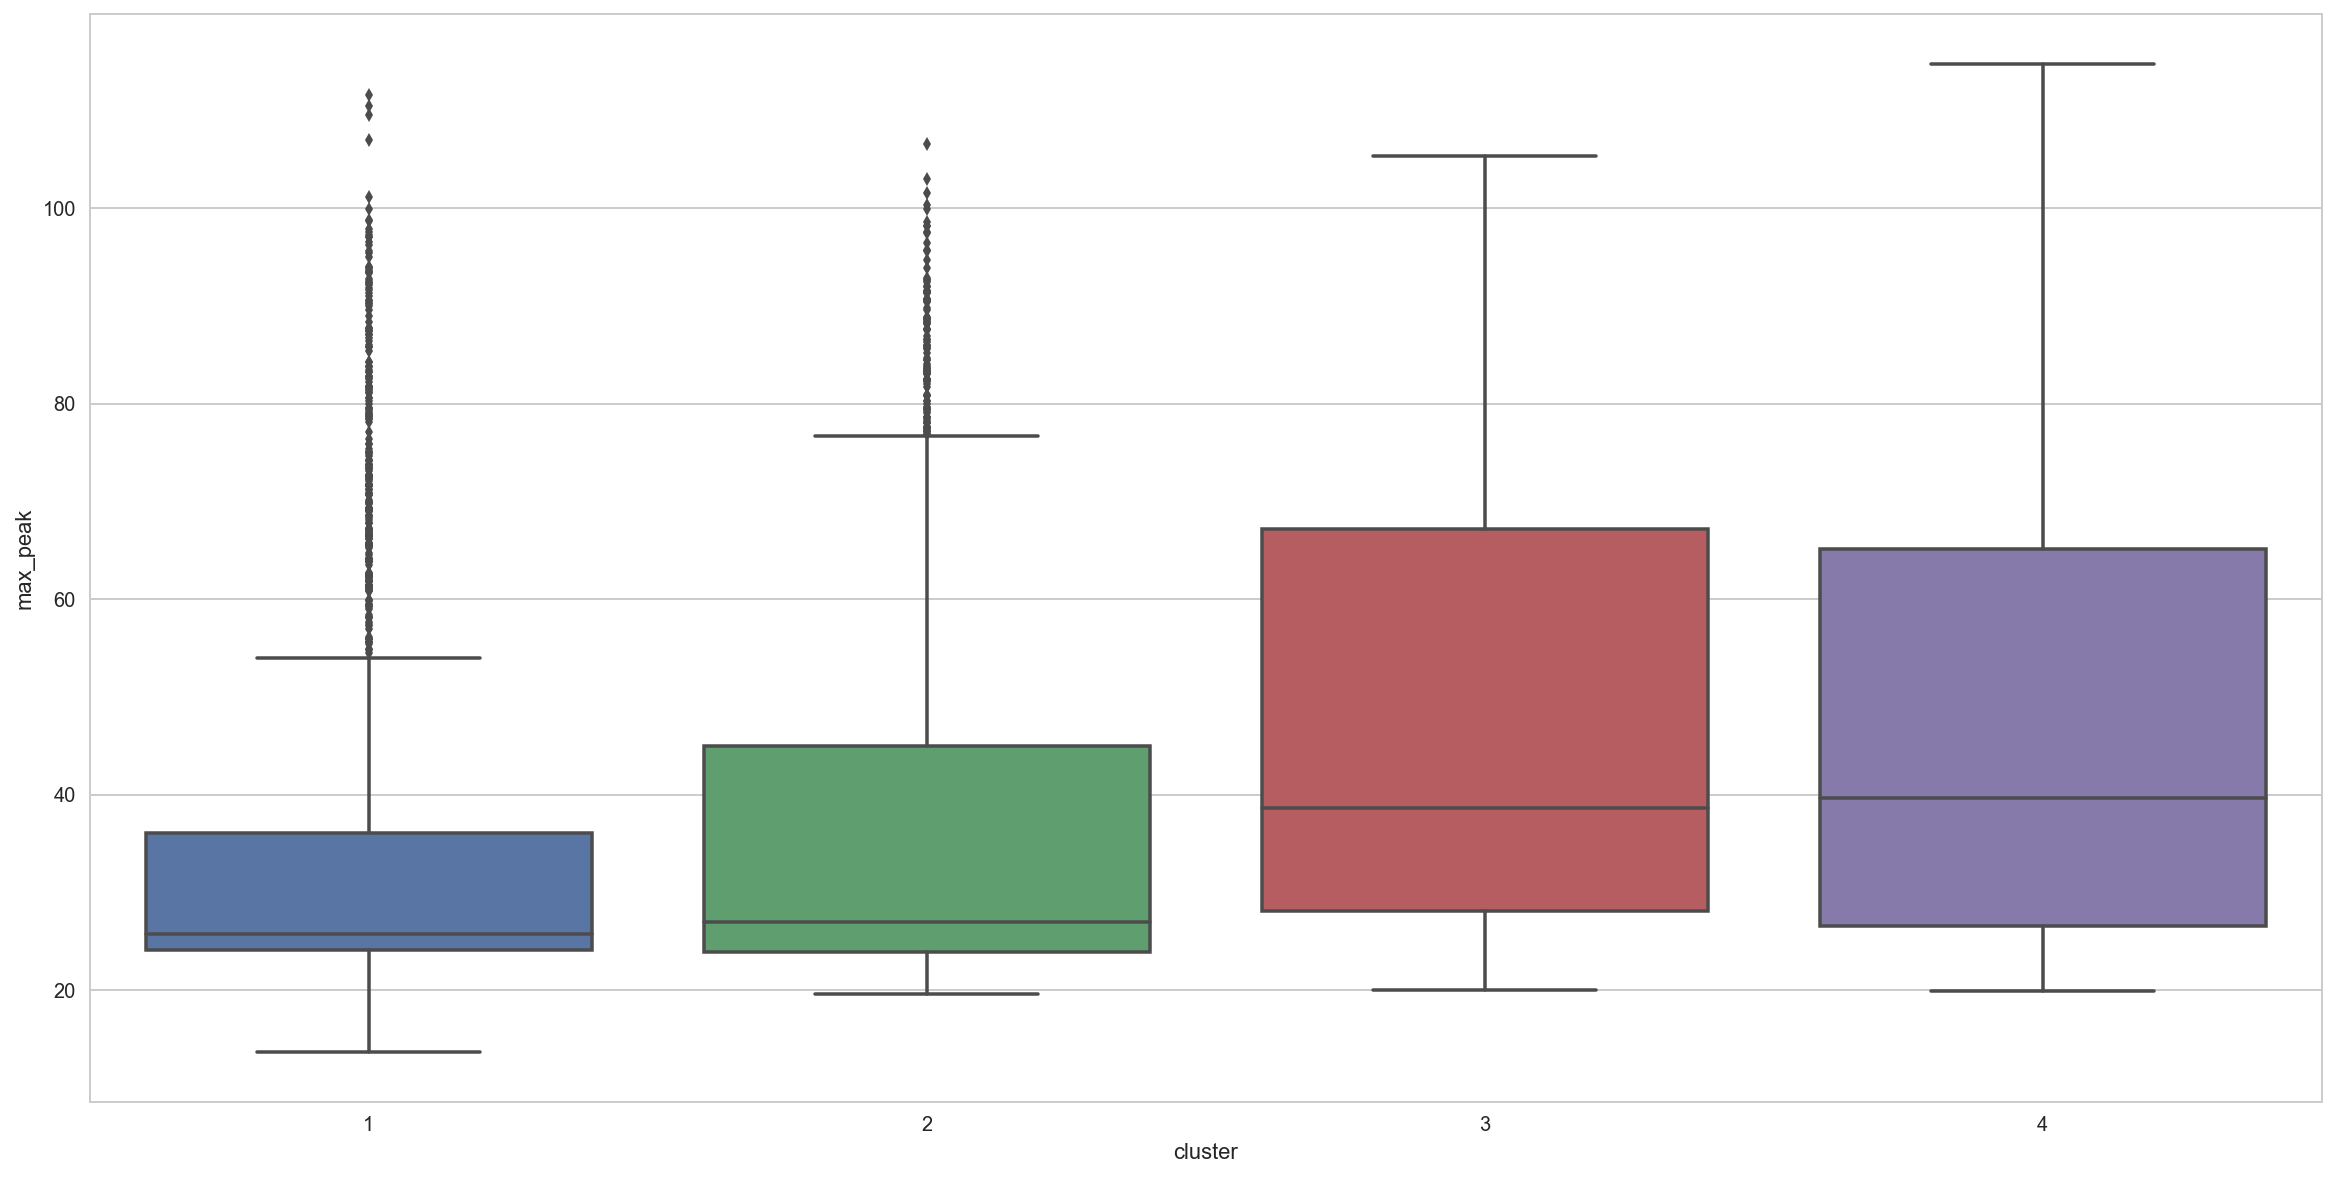

In [40]:
import seaborn as sns
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(ax = ax, x='cluster', y='max_peak', data=plot_data);

![Image](https://upload.wikimedia.org/wikipedia/commons/b/b1/Elements_of_a_boxplot.svg)

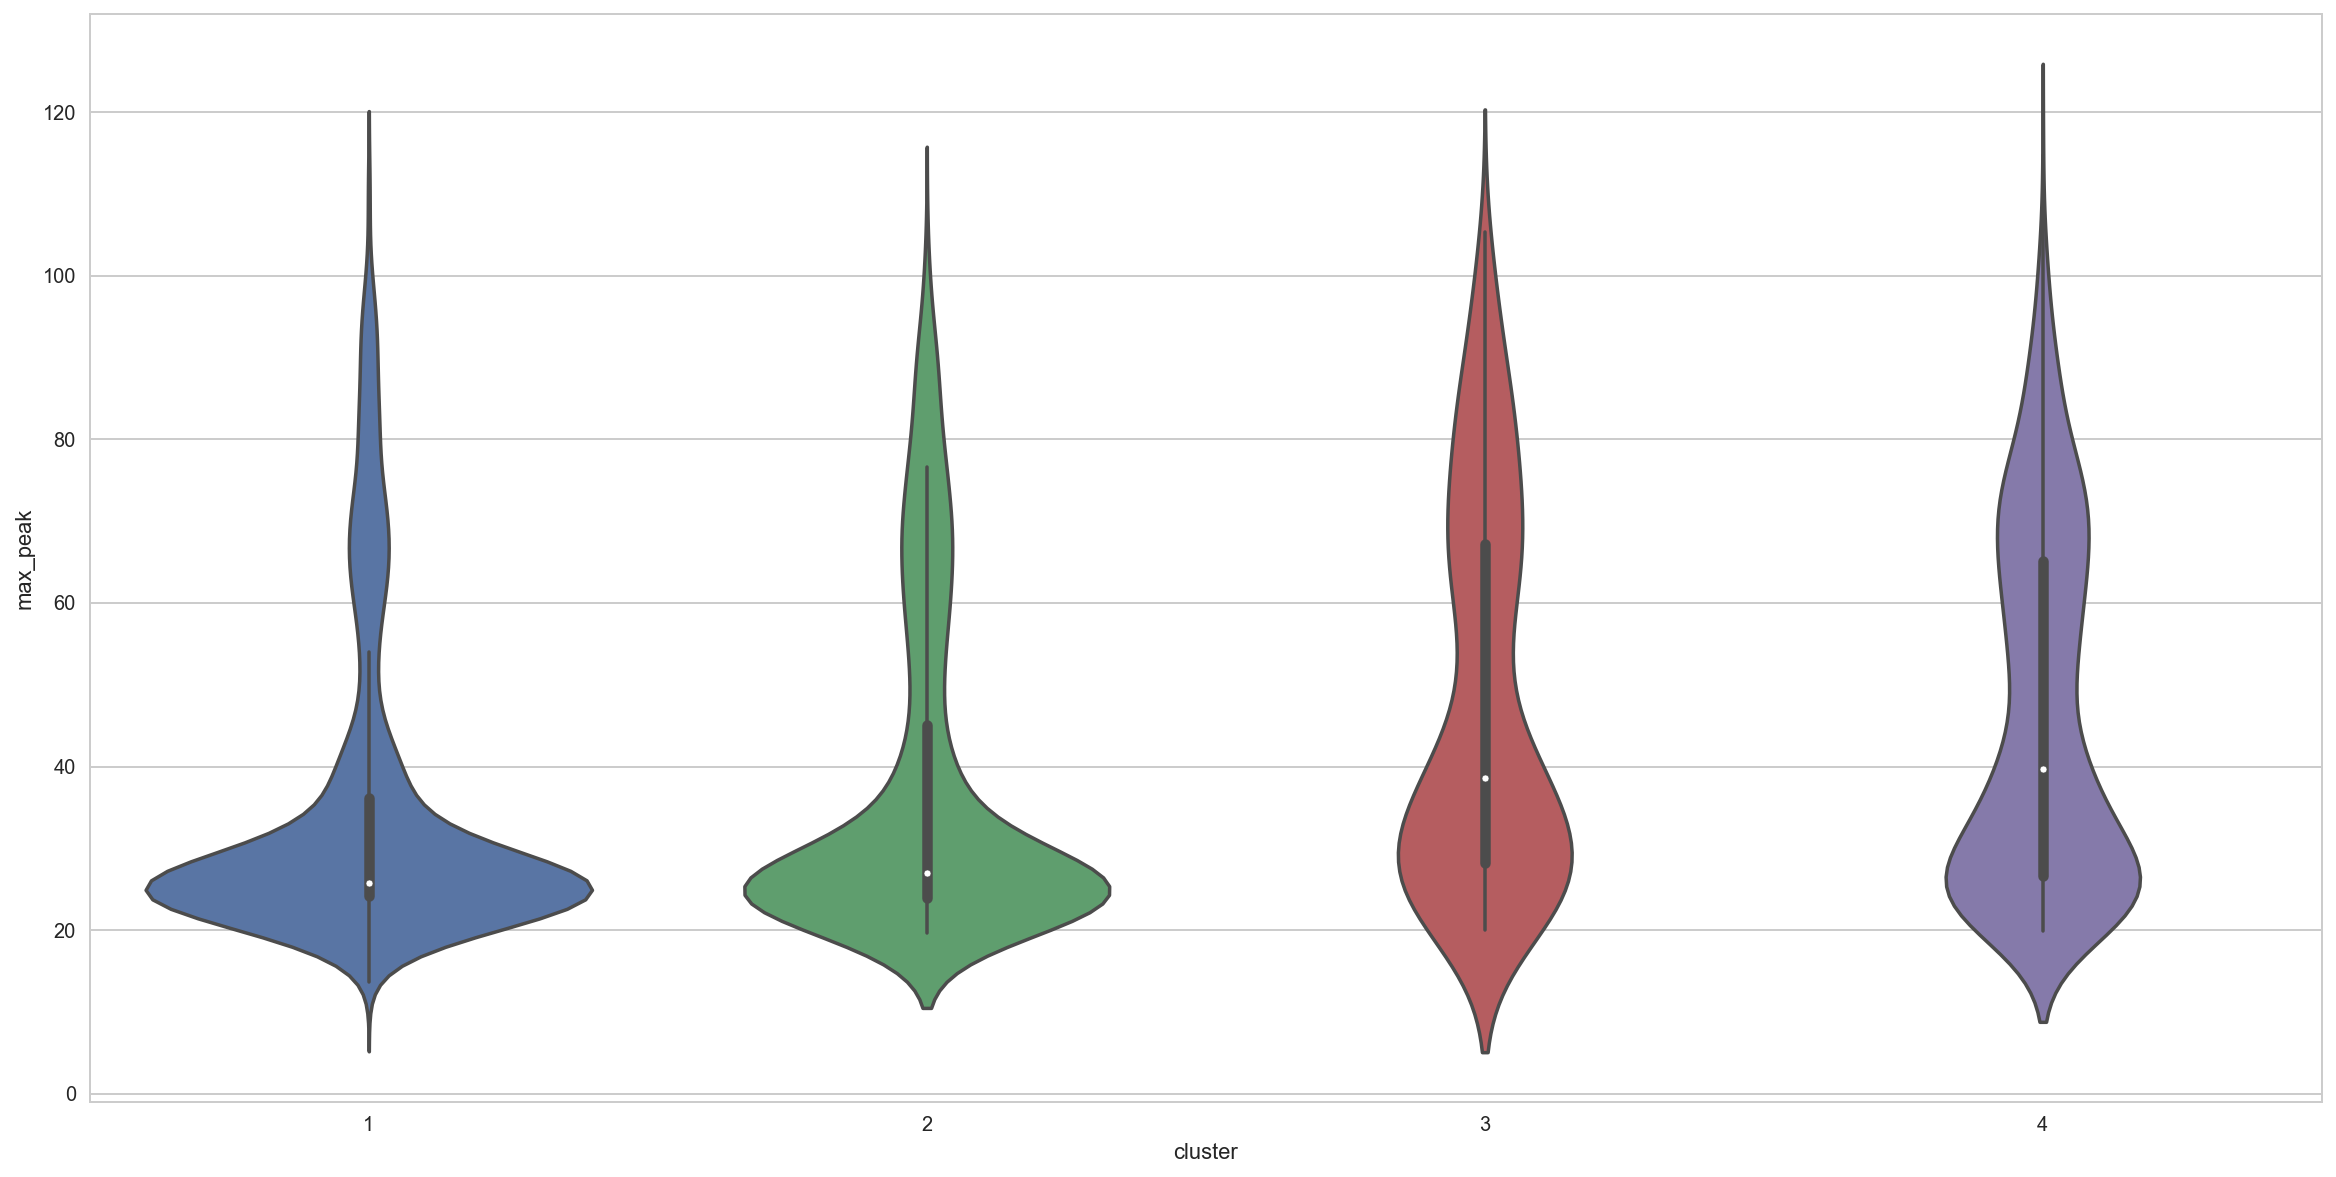

In [50]:
# Violin plot
fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(ax= ax, x='cluster', y='max_peak', data=plot_data)